# Support set size exploration

In [2]:
import os

import numpy as np
import pandas as pd
import duckdb
import seaborn as sns
import matplotlib.pyplot as plt

# Data access

In [14]:
def get_run_info(filepath):

    # Split the string at each slash to isolate each part of the path
    parts = filepath.split("/")

    # The target part is the one that contains 'params.dataset' and 'params.support_set_size'
    target = [part for part in parts if "params.dataset" in part][0]

    # Split the target part at each comma
    params = target.split(",")

    # Split each parameter at the equals sign and take the second part
    dataset = params[0].split("=")[1]

    return {"dataset": dataset}

In [76]:
INPUT_DIR = "/Users/sethhowes/Desktop/FS-Tox/multirun/2023-08-08/16-28-37"
run_dirs = [os.path.join(INPUT_DIR, run_dir) for run_dir in os.listdir(INPUT_DIR) if os.path.isdir(os.path.join(INPUT_DIR, run_dir))]
run_dirs = [f"{run_dir}/data/processed/score/*.parquet" for run_dir in run_dirs]

support_sizes = [16, 32, 64, 128, 256]
datasets = ["toxcast", "toxval", "nci60", "cancerrx", "prism", "acute_oral_toxicity"]

con = duckdb.connect()

dfs = []

for run_dir in run_dirs:
    info = get_run_info(run_dir)
    query = f"""
    SELECT delta_auc_pr, support_set_size
    FROM read_parquet('{run_dir}')
    """
    try:
        df = con.execute(query).df()
        df["dataset"] = info["dataset"]
        dfs.append(df)
    except Exception as e:
        print(f"No data for {info['dataset']} with support set size of {info['support_set_size']}")

        
# Concatenate all dataframes into one
df_final = pd.concat(dfs, ignore_index=True)

In [ ]:
# Incorporate results from MEIC

In [32]:
df_final.head()

,delta_auc_pr,support_set_size,dataset
0,0.038845,16,nci60
1,0.089025,64,nci60
2,0.036942,256,nci60
3,0.039815,128,nci60
4,0.050483,32,nci60


In [77]:
# Load MEIC data
dir = "/Users/sethhowes/Desktop/FS-Tox/outputs/2023-08-08/20-40-39/data/processed/score/*"
meic = con.execute(f"SELECT delta_auc_pr, support_set_size FROM read_parquet('{dir}')").df()
meic['dataset'] = 'meic'
datasets.append('meic')
df_final = pd.concat([df_final, meic]).reset_index(drop=True)

# Overall performance by support set size

In [79]:
df_final["support_set_size"] = df_final['support_set_size'].astype(int)

16
32
64
128
256


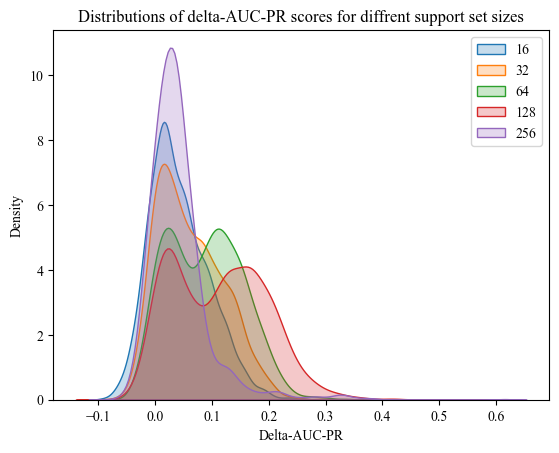

In [80]:
# Create overlapping distribution plots
support_sizes = [16, 32, 64, 128, 256]

for support_size in support_sizes:
    print(support_size)
    tmp = df_final[df_final["support_set_size"] == support_size]
    sns.kdeplot(x=tmp["delta_auc_pr"], label=support_size, fill=True)

# Provide labels and title
plt.xlabel("Delta-AUC-PR")
plt.ylabel("Density")
plt.title("Distributions of delta-AUC-PR scores for diffrent support set sizes")

# Display the legend
plt.legend()

# Show the plot
plt.show()

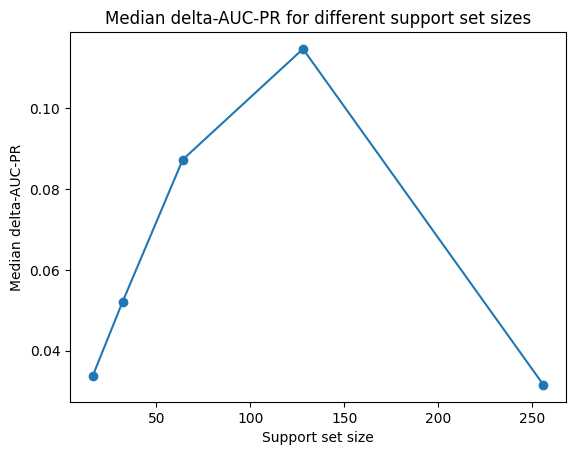

In [43]:
median_vals = []

# Get median delta-AUC-PR for each support set size
for support_size in support_sizes:
    tmp = df_final[df_final["support_set_size"] == support_size]
    median_vals.append(tmp["delta_auc_pr"].median())
    
# Plot median delta-AUC-PR for each support set size as line plot
plt.plot(support_sizes, median_vals, marker="o")
plt.xlabel("Support set size")
plt.ylabel("Median delta-AUC-PR")
plt.title("Median delta-AUC-PR for different support set sizes")
plt.show()

# Performance by dataset

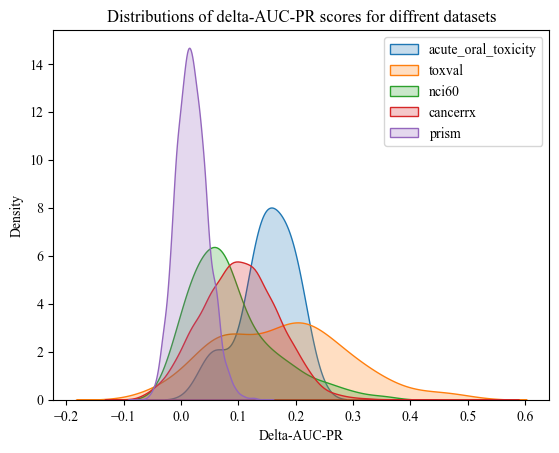

In [87]:
datasets = ["acute_oral_toxicity", "toxval", "nci60", "cancerrx", "prism"]

# Create overlapping distribution plots
for dataset in datasets:
    tmp = df_final[df_final["dataset"] == dataset]
    sns.kdeplot(x=tmp["delta_auc_pr"], label=dataset, fill=True)

# Provide labels and title
plt.xlabel("Delta-AUC-PR")
plt.ylabel("Density")
plt.title("Distributions of delta-AUC-PR scores for diffrent datasets")

# Display the legend
plt.legend()

# Show the plot
plt.show()

# Performance by dataset by support set size

In [85]:
datasets.append('meic')

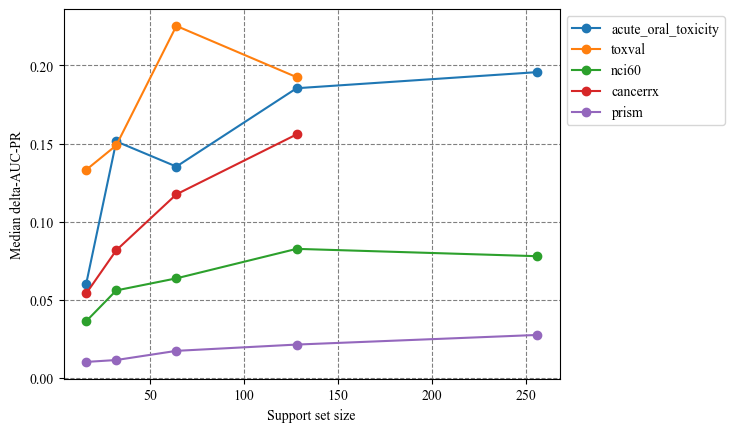

In [90]:
plt.rcParams['font.family'] = 'Times New Roman'
median_collate = []
# Get median delta-AUC-PR for each support set size
for dataset in datasets:
    median_vals = []
    for support_size in support_sizes:
        tmp = df_final[(df_final["support_set_size"] == support_size) & (df_final["dataset"] == dataset)]
        median_vals.append(tmp["delta_auc_pr"].median())
    median_collate.append(median_vals)

    if not all(np.isnan(median_vals)):
        # Filter out any NaN values and plot
        valid_indices = ~np.isnan(median_vals)
        plt.plot(np.array(support_sizes)[valid_indices], np.array(median_vals)[valid_indices], marker="o", label=dataset)

plt.grid(True,which="both",ls="--",c='gray')
plt.xlabel("Support set size")
plt.ylabel("Median delta-AUC-PR")
# Place the legend to the right of the plot
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.show()


In [99]:
support_16 = []
support_32 = []
for median_vals in median_collate:
    support_16.append(median_vals[0])
    support_32.append(median_vals[1])

In [101]:
np.mean(support_32) - np.mean(support_16)

0.031068262194527074

In [102]:
support_128 = []
support_256 = []
for median_vals in median_collate:
    support_128.append(median_vals[3])
    support_256.append(median_vals[4])

In [104]:
support_128

[0.18539750861172577,
 0.19248558456836662,
 0.08261365260819947,
 0.15583796357555266,
 0.021370732779432744]

In [117]:
mask = ~np.isnan(support_256)
difference = np.mean(np.array(support_128)[mask]) - np.mean(np.array(support_256)[mask])

In [118]:
difference

-0.00391733340740387

I will also add some error bars to this plot.

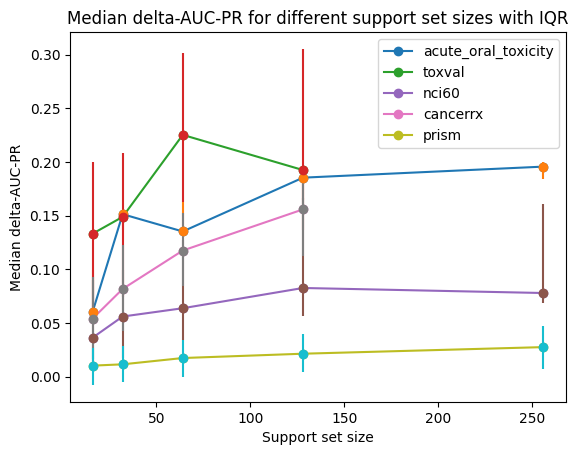

In [56]:
non_zero_datatsets = []
for dataset in datasets:
    median_vals = []
    lower_vals = [] # List to store the lower bounds of the IQR
    upper_vals = [] # List to store the upper bounds of the IQR

    for support_size in support_sizes:
        tmp = df_final[(df_final["support_set_size"] == support_size) & (df_final["dataset"] == dataset)]
        median_vals.append(tmp["delta_auc_pr"].median())
        lower_vals.append(tmp["delta_auc_pr"].quantile(0.25)) # Compute Q1
        upper_vals.append(tmp["delta_auc_pr"].quantile(0.75)) # Compute Q3
    
    if not all(np.isnan(median_vals)):
        # Filter out any NaN values and plot
        valid_indices = ~np.isnan(median_vals)
        plt.plot(np.array(support_sizes)[valid_indices], np.array(median_vals)[valid_indices], marker="o", label=dataset)
        # Plot the IQR as error bars
        plt.errorbar(support_sizes, median_vals, [np.array(median_vals) - np.array(lower_vals), np.array(upper_vals) - np.array(median_vals)], fmt='o')

plt.xlabel("Support set size")
plt.ylabel("Median delta-AUC-PR")
plt.title("Median delta-AUC-PR for different support set sizes with IQR")
plt.legend()
plt.show()
